In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### Load and Preprocess Data

In [2]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)


""" Normallization and Augmentation
"""
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


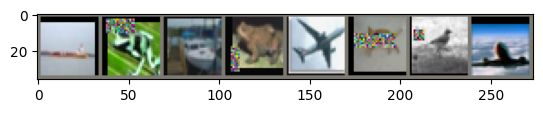

ship  frog  ship  frog  airplane cat   bird  airplane


In [3]:
def imshow(img):
    """ Un-normalize & plot a data

    Reverse normalization during pre-process step, clamp to valid range and display with matplotlib
    Parameters:
        img (torch.Tensor): A grid image tensor of shape (C, H, W)
    returns:
    """
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))

classes = ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

### Conv + Pooling CNN model

In [4]:
class ConvPoolCNN(nn.Module):
    """ Convolutional Neural Network using a Conv-Pool architecture.

    Architecture:
        - Three convolutional blocks:
            Conv2D layers -> Batch Normalization -> ReLu activation
        - MaxPooling (2x2).
        - Global Average Pooling for generalzation, reduce feature number and overfitting.
        - Fully connected layer mapping extracted features to class number.

    Input:
        Tensor of shape (N, 3, 32, 32)
            N = batch size
            3 = RGB channels
            32x32 = image size

    Output:
        Tensor of shape (N, num_classes)
            Raw class logits for classification.

    Parameters:
        num_classes (int):
            Number of output classes. Default is 10.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)
        x = self.block2(x)
        x = self.pool(x)  
        x = self.block3(x)
        x = self.pool(x) 
        x = self.gap(x)  
        x = torch.flatten(x, 1)
        return self.fc(x)

### Strided-Conv CNN model

In [5]:
class StridedConvCNN(nn.Module):
    """ Convolutional Neural Network using a Strided Convolution architecture.

    Architecture:
        - Initial convolutional block1:
            Conv2D -> Batch Normalization -> ReLU activation
        - Three convolutional stages:
            Each stage contains two Conv2D layers with Batch Normalization
            Conv2D (stride=2 to downsampling) -> Batch Normalization -> ReLU activation -> Conv2D -> Batch Normalization -> ReLU activation
        - Global Average Pooling for generalzation, reduce feature number and overfitting.
        - Fully connected layer mapping extracted features to class number.

    Input:
        Tensor of shape (N, 3, 32, 32)
            N = batch size
            3 = RGB channels
            32x32 = image resolution

    Output:
        Tensor of shape (N, num_classes)
            Raw class logits for classification.

    Parameters:
        num_classes (int):
            Number of output classes. Default is 10.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [6]:
@torch.no_grad()
def accuracy(model, loader):
    """ Compute classification accuracy of a trained model 

    This function evaluates the model on a given dataset loader
    without computing gradients. The model is set to evaluation
    mode to disable behaviors such as dropout and to use running
    statistics in batch normalization layers.
    
    @torch.no_grad() decorator disables gradient computation
    to reduce memory usage and improve evaluation speed.

    Parameters:
        model (nn.Module):
            The trained neural network model to evaluate.

        loader (DataLoader):
            PyTorch DataLoader providing input batches and labels.

    Returns:
        (float):
            Classification accuracy.
    """
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total

### Training and Evaluating

In [7]:
def train_model(model, epochs=10, lr=0.001):
    """ A function training neural network model evaluate its performance.

    This function performs supervised training using the Adam optimizer,
    learning rate scheduler. Training and test accuracy are computed
    at the end of each epoch.

    Parameters:
        model (nn.Module):
            The neural network model to be trained.

        epochs (int):
            Number of training epochs. Default is 10.

        lr (float):
            Initial learning rate for the Adam optimizer. Default is 0.001.

    Returns:
        model (nn.Module):
            The trained model.

        train_acc_hist (list of float):
            Training accuracy recorded at each epoch.

        test_acc_hist (list of float):
            Test accuracy recorded at each epoch.
    """
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs
    )

    train_acc_hist, test_acc_hist = [], []
    best_test = 0.0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        tr_acc = accuracy(model, train_loader)
        te_acc = accuracy(model, test_loader)

        train_acc_hist.append(tr_acc)
        test_acc_hist.append(te_acc)

        best_test = max(best_test, te_acc)

        print(f"Epoch [{epoch:02d}/{epochs}] "
              f"loss={running_loss/len(train_loader):.4f} "
              f"train_acc={tr_acc:.4f} "
              f"test_acc={te_acc:.4f} "
              f"best={best_test:.4f}")

    return model, train_acc_hist, test_acc_hist

In [8]:
EPOCHS = 20

print("\n=== Conv+Pool Model ===")
modelA, trainA, testA = train_model(ConvPoolCNN(), epochs=EPOCHS)

print("\n=== Strided-Conv Model ===")
modelB, trainB, testB = train_model(StridedConvCNN(), epochs=EPOCHS)


=== Conv+Pool Model ===
Epoch [01/20] loss=1.3575 train_acc=0.5728 test_acc=0.5945 best=0.5945
Epoch [02/20] loss=0.9382 train_acc=0.6658 test_acc=0.6651 best=0.6651
Epoch [03/20] loss=0.7659 train_acc=0.6924 test_acc=0.7058 best=0.7058
Epoch [04/20] loss=0.6593 train_acc=0.7703 test_acc=0.7727 best=0.7727
Epoch [05/20] loss=0.5924 train_acc=0.7745 test_acc=0.7780 best=0.7780
Epoch [06/20] loss=0.5354 train_acc=0.7822 test_acc=0.7793 best=0.7793
Epoch [07/20] loss=0.4992 train_acc=0.8342 test_acc=0.8278 best=0.8278
Epoch [08/20] loss=0.4606 train_acc=0.7825 test_acc=0.7838 best=0.8278
Epoch [09/20] loss=0.4237 train_acc=0.8485 test_acc=0.8413 best=0.8413
Epoch [10/20] loss=0.3925 train_acc=0.8430 test_acc=0.8233 best=0.8413
Epoch [11/20] loss=0.3616 train_acc=0.8782 test_acc=0.8570 best=0.8570
Epoch [12/20] loss=0.3372 train_acc=0.8646 test_acc=0.8379 best=0.8570
Epoch [13/20] loss=0.3111 train_acc=0.8892 test_acc=0.8641 best=0.8641
Epoch [14/20] loss=0.2917 train_acc=0.9040 test_acc=

### Results

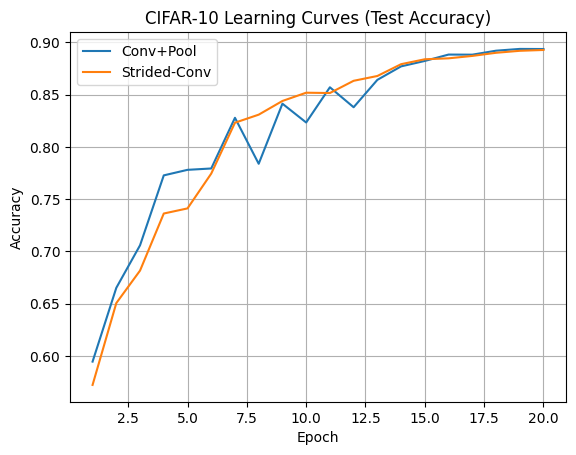

In [9]:
plt.figure()
plt.plot(range(1, EPOCHS + 1), testA, label="Conv+Pool")
plt.plot(range(1, EPOCHS + 1), testB, label="Strided-Conv")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CIFAR-10 Learning Curves (Test Accuracy)")
plt.grid(True)
plt.legend()
plt.show()

### Note

the implementation is based from an example code given from previous class.

ChatGPT was use in assisting a development to improve accuracy in:

    + suggesting CNN architecture
    + adding batch normalizationn
    + ploting
    + Normalizing data respect to 3-channel RGB
    + use learning rate scheduler.